In [2]:
import sys
sys.path.append('../')
import time
from typing import Optional
import torch
from utils.utils import sliced_ot_loss, local_loss, fully_connected_adj, init_random_seeds
from utils.visualize import coord2scatter, plot_edge_index
from tqdm.notebook import tqdm
from data.datasets import get_geometric_graph
from matplotlib import pyplot as plt
import matplotlib.animation as animation
%matplotlib widget

In [3]:
from importlib import reload

import data.datasets
import utils
import utils.utils
reload(data.datasets)
reload(utils)
reload(utils.utils)

<module 'utils.utils' from 'd:\\Onedrive\\OneDrive - TU Eindhoven\\Graduation Project\\egnca\\notebooks\\..\\utils\\utils.py'>

In [4]:
def create_cube_cloud(
    length: Optional[int] = 8,
    radius: Optional[float] = 0.15
):
    values = torch.linspace(0, 1, steps=length)
    coord = torch.stack(torch.meshgrid(values, values, values, indexing='xy')).reshape(3, -1).T
    dist = torch.norm(coord - coord.unsqueeze(1), dim=-1) < radius
    dist.fill_diagonal_(0)
    edge_index = dist.nonzero().T
    return coord, edge_index

In [5]:
def optimize(
    target_coord: torch.Tensor,
    loss_fn,
    steps: Optional[int] = 1_000,
    lr: Optional[float] = 1e-1,
    anchor_coord: Optional[torch.Tensor] = None,
    coord: Optional[torch.Tensor] = None,
    leave_pb: Optional[bool] = True,
    save_x_steps: Optional[int] = 0,
    **loss_fn_kwargs,
):
    if coord is None:
        coord = torch.nn.Parameter(torch.randn_like(target_coord))
        if anchor_coord is not None:
            coord.data[-anchor_coord.shape[0]:] = anchor_coord
    if anchor_coord is not None:
        anchor_coord = anchor_coord.to(coord.device)
    optimizer = torch.optim.Adam([coord], lr=lr)  # a high learning rate seems to be preferable
    pb = tqdm(range(steps), leave=leave_pb)
    inter_states = [coord.clone().detach()]
    best_loss = float('inf')
    steps_since_best = 0
    for training_step in pb:
        # you may want to save coord at every step (using coord.clone()) so that you can show the full trajectory!
        loss = loss_fn(coord, target_coord, **loss_fn_kwargs)
        if loss.isnan() or loss.isinf():
            print('Loss is NaN or inf, stopping')
            break
        if loss < best_loss:
            best_loss = loss
            steps_since_best = 0
        else:
            steps_since_best += 1
            if steps_since_best > 100:
                print('Reducing lr')
                optimizer.param_groups[0]['lr'] *= 0.5
                steps_since_best = 0
        optimizer.zero_grad()
        loss.backward()
        if anchor_coord is not None:
            # freeze the anchor points
            # print(coord.shape)
            # print(anchor_coord.shape)
            coord.grad[-anchor_coord.shape[0]:] = 0
        # assert coord[-anchor_coord.shape[0]:].allclose(anchor_coord)
        optimizer.step()
        if save_x_steps > 0 and training_step % save_x_steps == 0:
            inter_states.append(coord.clone().detach())
        # assert coord[-anchor_coord.shape[0]:].allclose(anchor_coord)
        pb.set_description(f'loss = {float(loss):.6f}')
    
    if save_x_steps > 0 and training_step % save_x_steps != 0:
        inter_states.append(coord.clone().detach())
    
    return coord, inter_states

In [6]:
from utils.utils import compute_edge_index


def ot_with_dyn(coord, target_coord, edge_index, n_neighbours=4, distance=None, **kwargs):
    edge_index = compute_edge_index(edge_index, coord, torch.LongTensor([coord.shape[0]]), True, True, distance=None, n_neighbours=n_neighbours, compute_gradients=True)
    return sliced_ot_loss(coord, target_coord, edge_index=edge_index, **kwargs)

In [7]:
def original_loss(coord, target_coord):
    full_edge_index = fully_connected_adj(torch.LongTensor([coord.shape[0]]), sparse=True)
    edge_weight = torch.norm(coord[full_edge_index[0]] - coord[full_edge_index[1]], dim=-1)
    target_edge_weight = torch.norm(target_coord[full_edge_index[0]] - target_coord[full_edge_index[1]], dim=-1)
    loss_per_edge = torch.nn.functional.mse_loss(edge_weight, target_edge_weight)
    loss = loss_per_edge.mean()
    return loss

In [22]:
print('Final loss: ', loss_fn(coord, target_coord, edge_index=edge_index, penalty=True, penalty_dist=dist.max(), penalty_dist_min=dist.min()))
print('Final loss: ', float(loss_fn(coord, target_coord, **loss_kwargs)))

cpu_coord = coord.to('cpu')
cpu_edge_index = edge_index.to('cpu')
edge_index_r = compute_edge_index(cpu_edge_index, cpu_coord, torch.LongTensor([cpu_coord.shape[0]]), True, True, distance=None, n_neighbours=4, compute_gradients=True)

dist2 = torch.norm(cpu_coord[edge_index_r[0]] - cpu_coord[edge_index_r[1]], dim=-1)

Final loss:  (tensor(0.0012, device='cuda:0', grad_fn=<MeanBackward1>), tensor(nan, device='cuda:0', grad_fn=<AddBackward0>))
Final loss:  nan


In [23]:
dist2

tensor([0.2577, 0.2510, 0.2858,  ..., 0.2401, 0.3420, 0.3360],
       grad_fn=<CopyBackwards>)

In [24]:
penalty = (torch.nn.functional.relu(dist2 - 0.3) ** 2).mean()
penalty += (torch.nn.functional.relu(0.1 - dist2) ** 2).mean()

penalty

tensor(0.0006, grad_fn=<AddBackward0>)

tensor(0.2169, device='cuda:0') tensor(0.2169, device='cuda:0') tensor(0.2169, device='cuda:0') tensor([0.2169, 0.2169, 0.2169, 0.2169, 0.2169], device='cuda:0')


Reducing lr
Reducing lr
Final loss:  1.120198205029066e-11


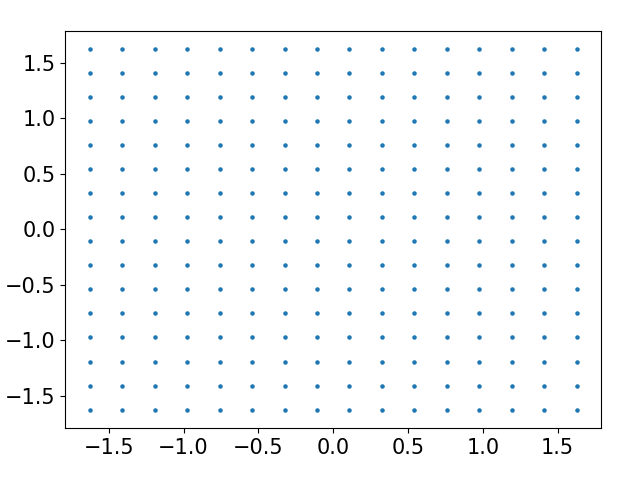

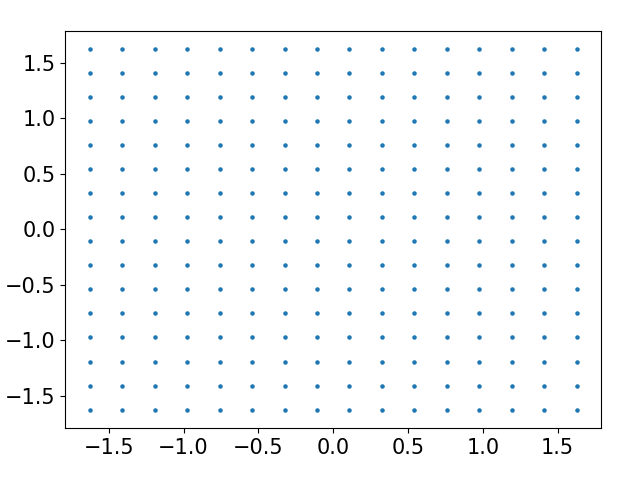

In [30]:
seed = 1
init_random_seeds(seed, deterministic=False)

device = 'cuda'
# target_coord = create_cube_cloud(10)[0].to(device)
graphs = ['Grid2d', 'x', 'Cube', 'Torus', 'Bunny']
target_coord, edge_index, anchor_coord = get_geometric_graph(graphs[0])#, anchor_structure='corners')
# print(target_coord[-anchor_coord.shape[0]:])
# print(anchor_coord)
target_coord = target_coord.to(device)
coord = torch.nn.Parameter(torch.randn_like(target_coord))
edge_index = edge_index.to(device)
edge_index_rel = compute_edge_index(None, coord, torch.LongTensor([coord.shape[0]]).to(device=device), True, True, distance=None, n_neighbours=8, compute_gradients=False)
dist = torch.norm(target_coord[edge_index[0]] - target_coord[edge_index[1]], dim=-1)
print(dist.min(), dist.mean(), dist.max(), dist.unique())
loss_fn = local_loss
loss_fn = sliced_ot_loss
# loss_fn = ot_with_dyn
# loss_fn = original_loss
# loss_kwargs = {"edge_index": edge_index, "extra_neighbours_penalty": True, "split_losses": False, "angle_type": "directed"}
# loss_kwargs = {"penalty": True, "penalty_dist": 0.3, "edge_index": edge_index, "split_losses": False, "n_neighbours": 6}
# loss_kwargs = {"penalty": True, "penalty_dist": dist.max().item(), "penalty_dist_min": dist.min().item(), "edge_index": edge_index, "split_losses": False}#, "n_neighbours": 4, "distance": None}
# loss_kwargs = {"penalty": True, "penalty_dist": 0.3, "edge_index": edge_index, "split_losses": False, "per_sample_loss": False}
# loss_kwargs = {"split_losses": False, "edge_index": edge_index}
loss_kwargs = {"split_losses": False}

coord2scatter(target_coord)

coord, inter_coords = optimize(target_coord, loss_fn, coord=coord, lr=1e-1, steps=1000, save_x_steps=10, **loss_kwargs)#, anchor_coord=anchor_coord, **loss_kwargs)

coord2scatter(coord)#, show_anchors=True, n_anchors=anchor_coord.shape[0])

print('Final loss: ', float(loss_fn(coord, target_coord, **loss_kwargs)))


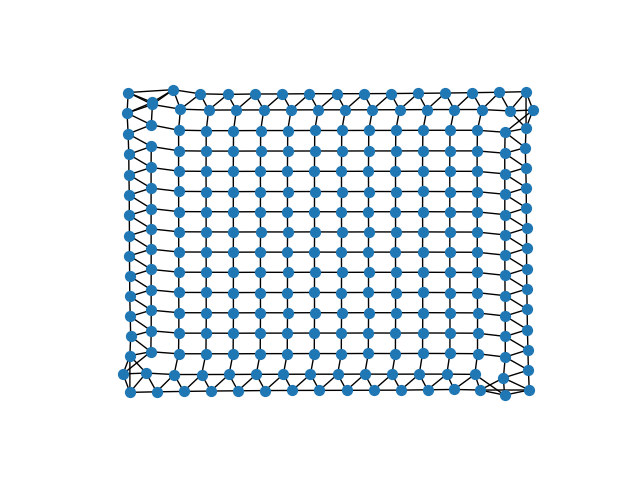

In [122]:
edge_index = compute_edge_index(edge_index, coord, torch.LongTensor([coord.shape[0]]), True, True, distance=None, n_neighbours=4, compute_gradients=False)
plot_edge_index(edge_index, coord)

In [27]:
box_dim = 1.0

coord_dim = coord.shape[-1]

def get_title(time_step, coord = None):
    title = '$t=%d$' % (time_step * 10)
    if coord is not None:
        loss = float(loss_fn(coord, target_coord, **loss_kwargs))
        title += ', $L=%.5f$' % loss
    return title

In [44]:
inter_coords_orig = [inter_coords[i].clone() for i in range(len(inter_coords))]

In [66]:
inter_coords_llpdir = [inter_coords[i].clone() for i in range(len(inter_coords))]

In [69]:
inter_coords_llpundir = [inter_coords[i].clone() for i in range(len(inter_coords))]

In [76]:
inter_coords_lldir = [inter_coords[i].clone() for i in range(len(inter_coords))]

In [73]:
inter_coords_llundir = [inter_coords[i].clone() for i in range(len(inter_coords))]

In [31]:
inter_coords_ot = [inter_coords[i].clone() for i in range(len(inter_coords))]

In [123]:
inter_coords_otp = [inter_coords[i].clone() for i in range(len(inter_coords))]

In [106]:
inter_coords_otp_dyn = [inter_coords[i].clone() for i in range(len(inter_coords))]

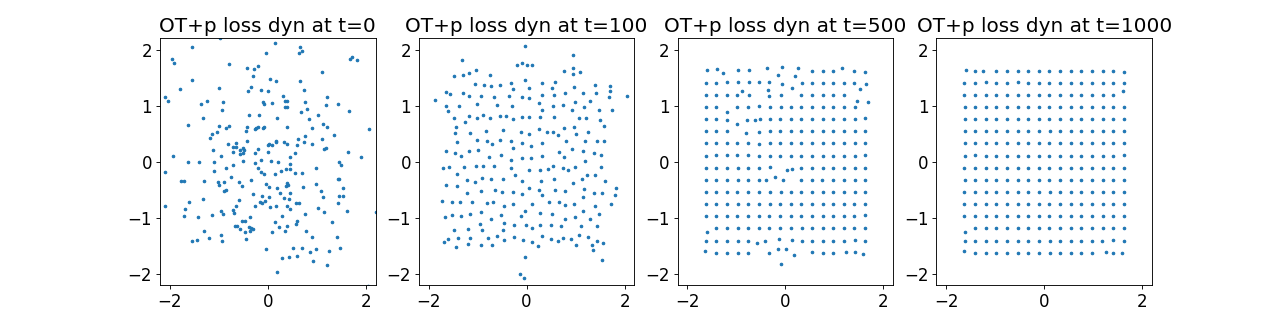

In [109]:
fig_progression2 = plt.figure(figsize=(16, 4), dpi=80)
fig_progression2.tight_layout()
ax1 = fig_progression2.add_subplot(141)
ax2 = fig_progression2.add_subplot(142)
ax3 = fig_progression2.add_subplot(143)
ax4 = fig_progression2.add_subplot(144)

coord2scatter(inter_coords_otp_dyn[0], box_dim=box_dim*2.2, ax=ax1, title='OT+p loss dyn at t=0', zero_center=True)
coord2scatter(inter_coords_otp_dyn[10], box_dim=box_dim*2.2, ax=ax2, title='OT+p loss dyn at t=100',zero_center=True)
coord2scatter(inter_coords_otp_dyn[50], box_dim=box_dim*2.2, ax=ax3, title='OT+p loss dyn at t=500', zero_center=True)
coord2scatter(inter_coords_otp_dyn[-1], box_dim=box_dim*2.2, ax=ax4, title='OT+p loss dyn at t=1000', zero_center=True)

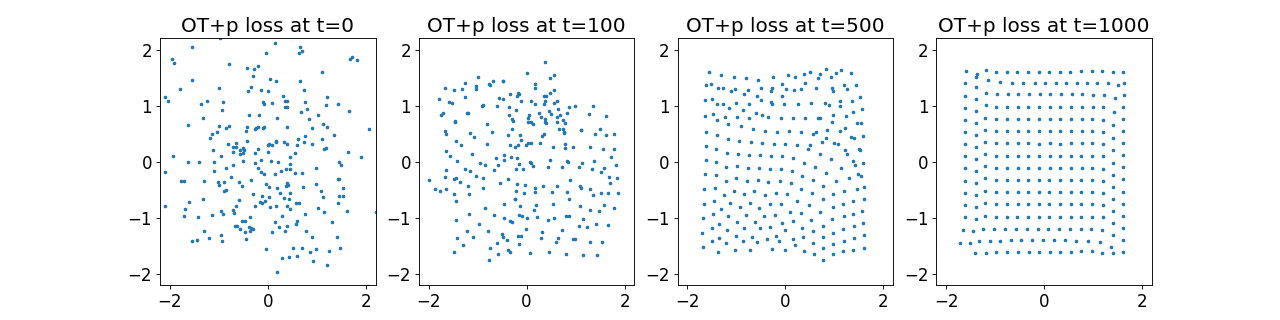

In [126]:
fig_progression2 = plt.figure(figsize=(16, 4), dpi=80)
fig_progression2.tight_layout()
ax1 = fig_progression2.add_subplot(141)
ax2 = fig_progression2.add_subplot(142)
ax3 = fig_progression2.add_subplot(143)
ax4 = fig_progression2.add_subplot(144)

coord2scatter(inter_coords_otp[0], box_dim=box_dim*2.2, ax=ax1, title='OT+p loss at t=0', zero_center=True)
coord2scatter(inter_coords_otp[10], box_dim=box_dim*2.2, ax=ax2, title='OT+p loss at t=100',zero_center=True)
coord2scatter(inter_coords_otp[50], box_dim=box_dim*2.2, ax=ax3, title='OT+p loss at t=500', zero_center=True)
coord2scatter(inter_coords_otp[100], box_dim=box_dim*2.2, ax=ax4, title='OT+p loss at t=1000', zero_center=True)

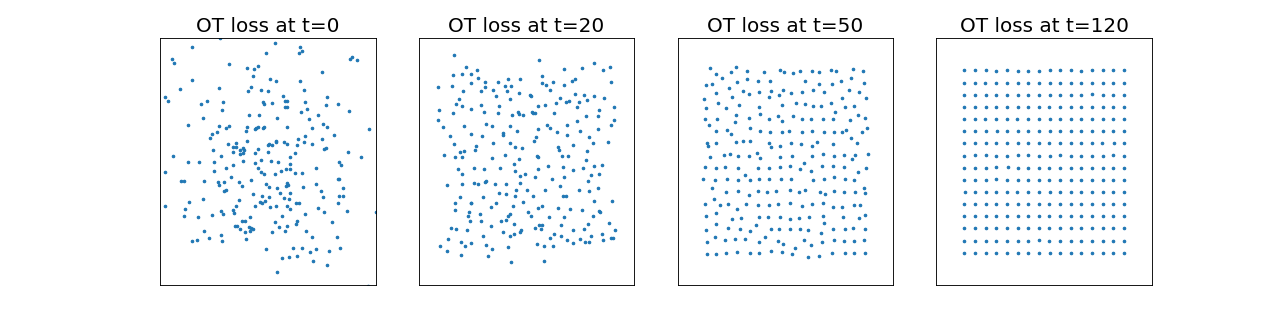

In [40]:
fig_progression2 = plt.figure(figsize=(16, 4), dpi=80)
fig_progression2.tight_layout()
ax1 = fig_progression2.add_subplot(141)
ax2 = fig_progression2.add_subplot(142)
ax3 = fig_progression2.add_subplot(143)
ax4 = fig_progression2.add_subplot(144)

axes = [ax1, ax2, ax3, ax4]
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

coord2scatter(inter_coords_ot[0], box_dim=box_dim*2.2, ax=ax1, title='OT loss at t=0', zero_center=True)
coord2scatter(inter_coords_ot[2], box_dim=box_dim*2.2, ax=ax2, title='OT loss at t=20',zero_center=True)
coord2scatter(inter_coords_ot[5], box_dim=box_dim*2.2, ax=ax3, title='OT loss at t=50', zero_center=True)
coord2scatter(inter_coords_ot[12], box_dim=box_dim*2.2, ax=ax4, title='OT loss at t=120', zero_center=True)

fig_progression2.savefig('../result_figures/ot_loss_progression.pdf', dpi=300)

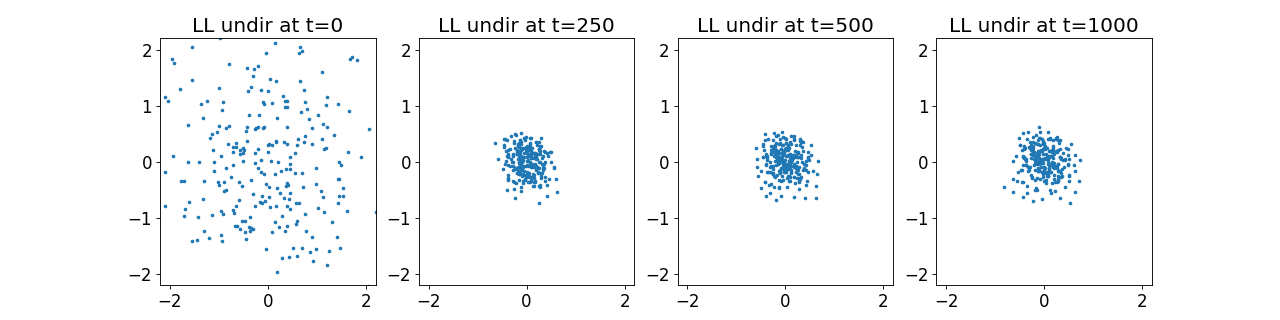

In [74]:
fig_progression2 = plt.figure(figsize=(16, 4), dpi=80)
fig_progression2.tight_layout()
ax1 = fig_progression2.add_subplot(141)
ax2 = fig_progression2.add_subplot(142)
ax3 = fig_progression2.add_subplot(143)
ax4 = fig_progression2.add_subplot(144)

coord2scatter(inter_coords_llundir[0], box_dim=box_dim*2.2, ax=ax1, title='LL undir at t=0', zero_center=True)
coord2scatter(inter_coords_llundir[25], box_dim=box_dim*2.2, ax=ax2, title='LL undir at t=250',zero_center=True)
coord2scatter(inter_coords_llundir[50], box_dim=box_dim*2.2, ax=ax3, title='LL undir at t=500', zero_center=True)
coord2scatter(inter_coords_llundir[-1], box_dim=box_dim*2.2, ax=ax4, title='LL undir at t=1000', zero_center=True)

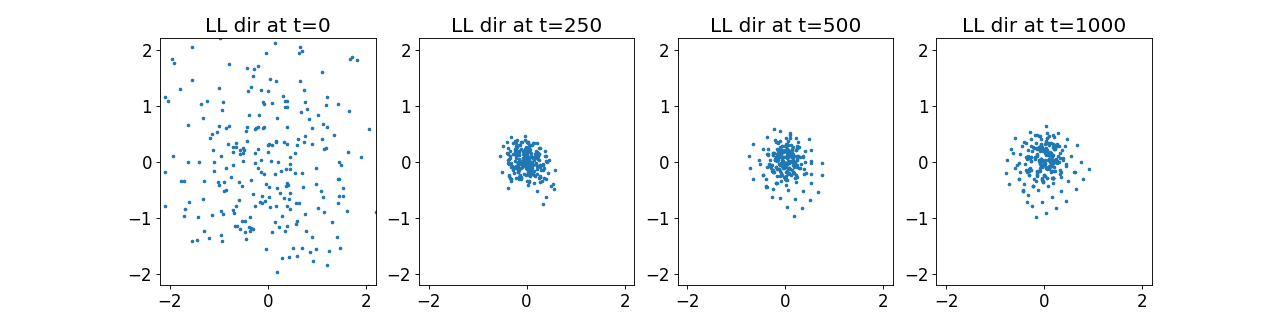

In [77]:
fig_progression2 = plt.figure(figsize=(16, 4), dpi=80)
fig_progression2.tight_layout()
ax1 = fig_progression2.add_subplot(141)
ax2 = fig_progression2.add_subplot(142)
ax3 = fig_progression2.add_subplot(143)
ax4 = fig_progression2.add_subplot(144)

coord2scatter(inter_coords_lldir[0], box_dim=box_dim*2.2, ax=ax1, title='LL dir at t=0', zero_center=True)
coord2scatter(inter_coords_lldir[25], box_dim=box_dim*2.2, ax=ax2, title='LL dir at t=250',zero_center=True)
coord2scatter(inter_coords_lldir[50], box_dim=box_dim*2.2, ax=ax3, title='LL dir at t=500', zero_center=True)
coord2scatter(inter_coords_lldir[-1], box_dim=box_dim*2.2, ax=ax4, title='LL dir at t=1000', zero_center=True)

In [19]:
inter_coords_llpdir = [inter_coords[i].clone() for i in range(len(inter_coords))]

In [16]:
box_dim = 1

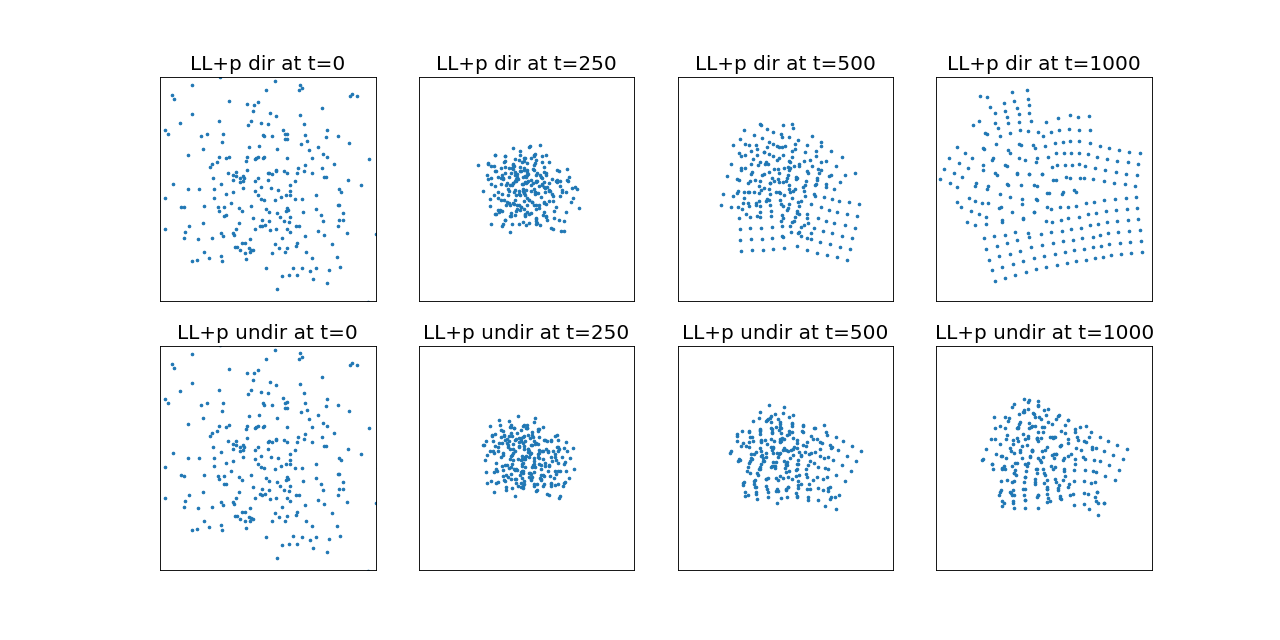

In [20]:
fig_progression2 = plt.figure(figsize=(16, 8), dpi=80)
fig_progression2.tight_layout()
ax1 = fig_progression2.add_subplot(241)
ax2 = fig_progression2.add_subplot(242)
ax3 = fig_progression2.add_subplot(243)
ax4 = fig_progression2.add_subplot(244)
ax5 = fig_progression2.add_subplot(245)
ax6 = fig_progression2.add_subplot(246)
ax7 = fig_progression2.add_subplot(247)
ax8 = fig_progression2.add_subplot(248)

axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

coord2scatter(inter_coords_llpdir[0], box_dim=box_dim*2.2, ax=ax1, title='LL+p dir at t=0', zero_center=True)
coord2scatter(inter_coords_llpdir[25], box_dim=box_dim*2.2, ax=ax2, title='LL+p dir at t=250',zero_center=True)
coord2scatter(inter_coords_llpdir[50], box_dim=box_dim*2.2, ax=ax3, title='LL+p dir at t=500', zero_center=True)
coord2scatter(inter_coords_llpdir[-1], box_dim=box_dim*2.2, ax=ax4, title='LL+p dir at t=1000', zero_center=True)

coord2scatter(inter_coords_llpundir[0], box_dim=box_dim*2.2, ax=ax5, title='LL+p undir at t=0', zero_center=True)
coord2scatter(inter_coords_llpundir[25], box_dim=box_dim*2.2, ax=ax6, title='LL+p undir at t=250',zero_center=True)
coord2scatter(inter_coords_llpundir[50], box_dim=box_dim*2.2, ax=ax7, title='LL+p undir at t=500', zero_center=True)
coord2scatter(inter_coords_llpundir[-1], box_dim=box_dim*2.2, ax=ax8, title='LL+p undir at t=1000', zero_center=True)

fig_progression2.savefig("progression grid local loss penalty.pdf", dpi=300)

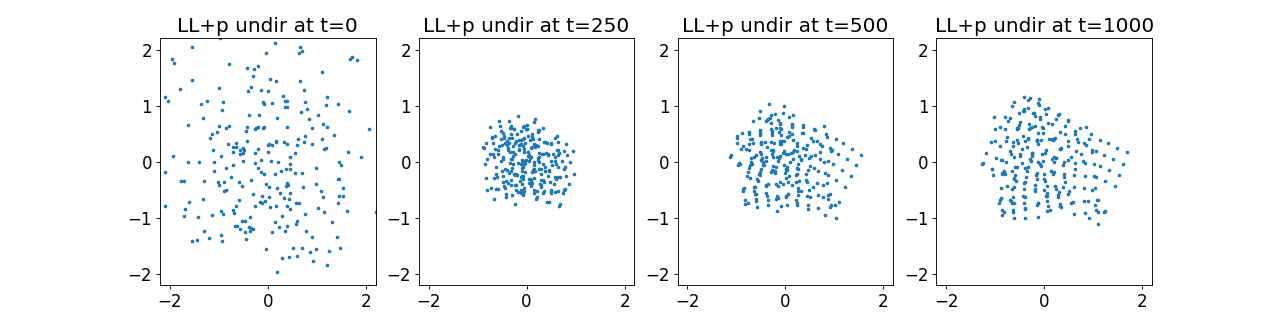

In [70]:
fig_progression2 = plt.figure(figsize=(16, 4), dpi=80)
fig_progression2.tight_layout()
ax1 = fig_progression2.add_subplot(141)
ax2 = fig_progression2.add_subplot(142)
ax3 = fig_progression2.add_subplot(143)
ax4 = fig_progression2.add_subplot(144)

coord2scatter(inter_coords_llpundir[0], box_dim=box_dim*2.2, ax=ax1, title='LL+p undir at t=0', zero_center=True)
coord2scatter(inter_coords_llpundir[25], box_dim=box_dim*2.2, ax=ax2, title='LL+p undir at t=250',zero_center=True)
coord2scatter(inter_coords_llpundir[50], box_dim=box_dim*2.2, ax=ax3, title='LL+p undir at t=500', zero_center=True)
coord2scatter(inter_coords_llpundir[-1], box_dim=box_dim*2.2, ax=ax4, title='LL+p undir at t=1000', zero_center=True)

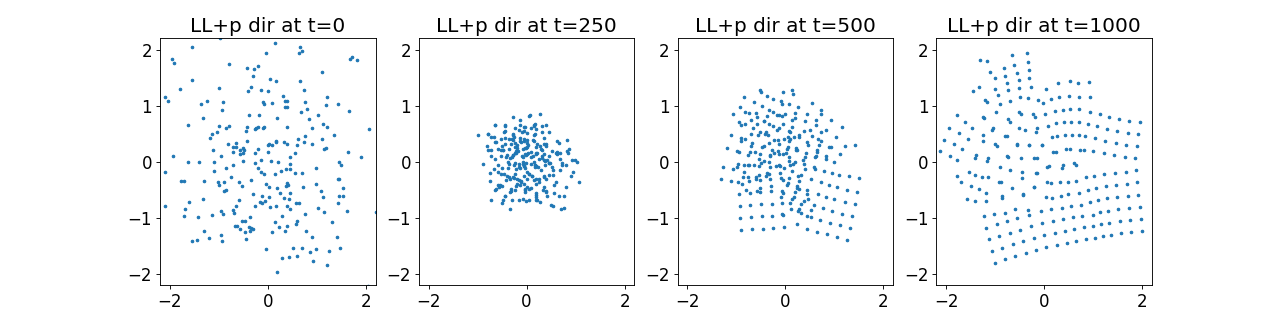

In [130]:
fig_progression2 = plt.figure(figsize=(16, 4), dpi=80)
fig_progression2.tight_layout()
ax1 = fig_progression2.add_subplot(141)
ax2 = fig_progression2.add_subplot(142)
ax3 = fig_progression2.add_subplot(143)
ax4 = fig_progression2.add_subplot(144)

coord2scatter(inter_coords_llpdir[0], box_dim=box_dim*2.2, ax=ax1, title='LL+p dir at t=0', zero_center=True)
coord2scatter(inter_coords_llpdir[25], box_dim=box_dim*2.2, ax=ax2, title='LL+p dir at t=250',zero_center=True)
coord2scatter(inter_coords_llpdir[50], box_dim=box_dim*2.2, ax=ax3, title='LL+p dir at t=500', zero_center=True)
coord2scatter(inter_coords_llpdir[-1], box_dim=box_dim*2.2, ax=ax4, title='LL+p dir at t=1000', zero_center=True)

fig_progression2.savefig('progression local loss with penalty, directed.png')

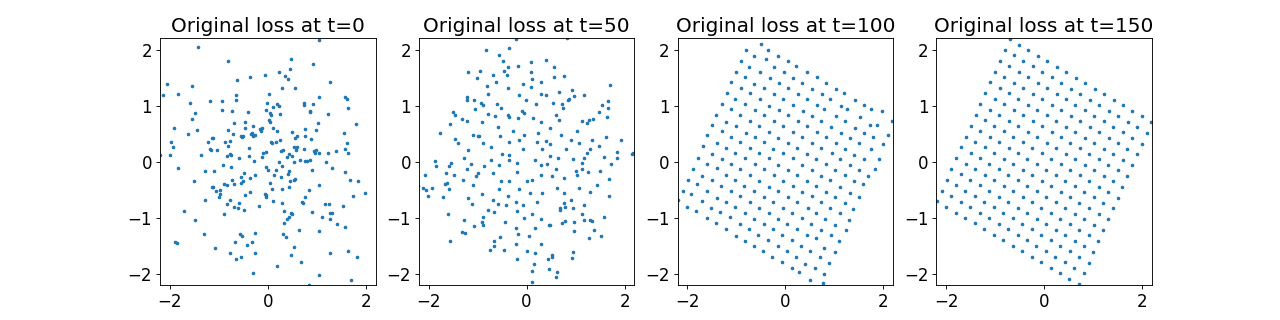

In [45]:
fig_progression = plt.figure(figsize=(16, 4), dpi=80)
fig_progression.tight_layout()
ax1 = fig_progression.add_subplot(141)
ax2 = fig_progression.add_subplot(142)
ax3 = fig_progression.add_subplot(143)
ax4 = fig_progression.add_subplot(144)

coord2scatter(inter_coords_orig[0], box_dim=box_dim*2.2, ax=ax1, title='Original loss at t=0', zero_center=True)
coord2scatter(inter_coords_orig[5], box_dim=box_dim*2.2, ax=ax2, title='Original loss at t=50',zero_center=True)
coord2scatter(inter_coords_orig[10], box_dim=box_dim*2.2, ax=ax3, title='Original loss at t=100', zero_center=True)
coord2scatter(inter_coords_orig[15], box_dim=box_dim*2.2, ax=ax4, title='Original loss at t=150', zero_center=True)

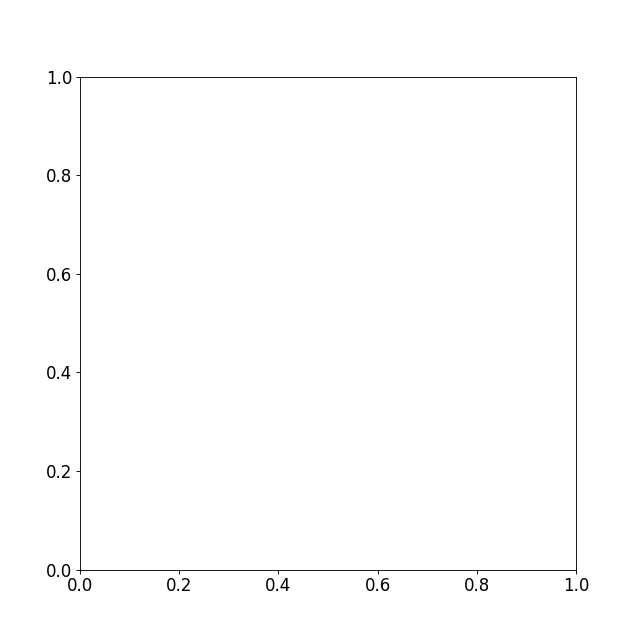

In [26]:
box_dim = 1

def animate(t):
    ax.clear()
    # if model.structured_seed:
    #     coord2scatter(inter_coords[t], box_dim=box_dim*2, ax=ax, title=get_title(t, inter_coords[t]), zero_center=True, show_anchors=True, n_anchors=model.encoder.anchor_feat.size(0))#, feat=inter_node_feats[t])
    # else:
    coord2scatter(inter_coords[t], box_dim=box_dim*2, ax=ax, title=get_title(t, inter_coords[t]), zero_center=True)
    # plot_edge_index(edge_index, coord=inter_coords[t], box_dim=box_dim*2, ax=ax, title=get_title(t, inter_coords[t]))

fig = plt.figure(figsize=(8, 8), dpi=80)
fig.tight_layout()
ax = fig.add_subplot(projection='3d' if coord.shape[-1] == 3 else None)
ani = animation.FuncAnimation(fig, animate, frames=range(len(inter_coords)), interval=250, repeat=False)

Text(0, 0.5, 'distance smoothness')

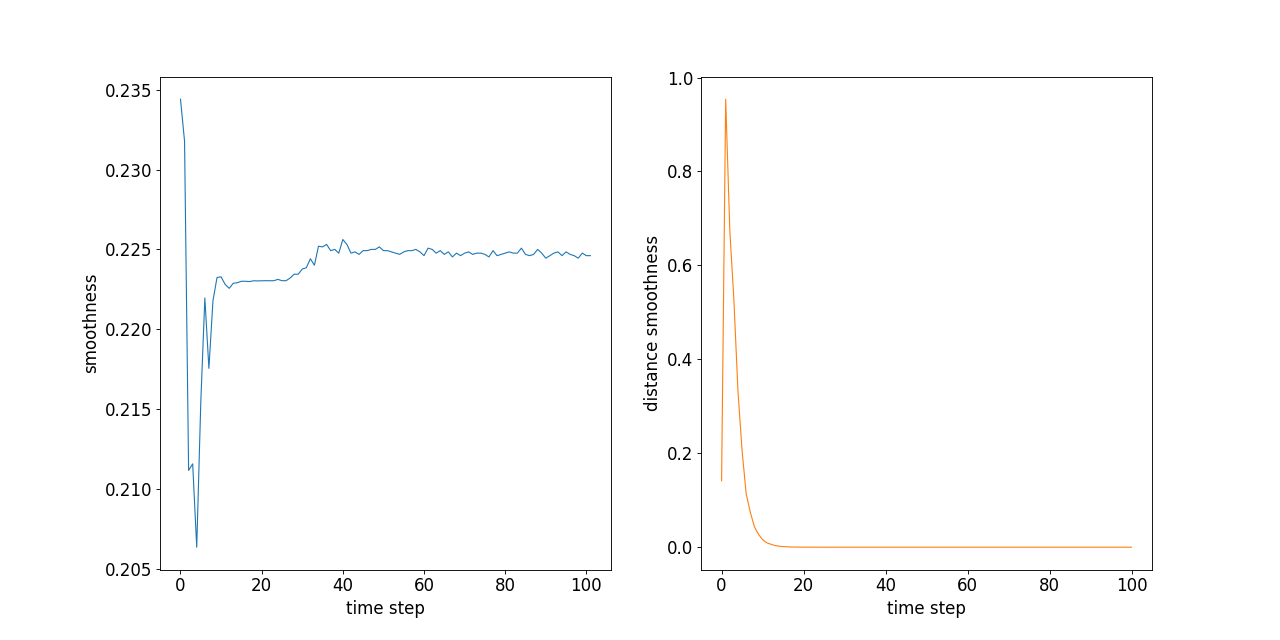

In [28]:
reload(utils.utils)
from utils.utils import smoothness, distance_smoothness


smoothnesses, s_mean, s_std = smoothness(inter_coords, edge_index, True)
dist_smoothnesses, ds_mean, ds_std = distance_smoothness(inter_coords)

# Plot smoothness with line plot without showing all x ticks
fig_smoothness = plt.figure(figsize=(16, 8), dpi=80)
fig_smoothness.tight_layout()
ax_smoothness = fig_smoothness.add_subplot(121)
ax_smoothness.plot(range(len(smoothnesses)), smoothnesses, color='tab:blue', linewidth=1)
ax_smoothness.xaxis.set_label_text('time step')
ax_smoothness.yaxis.set_label_text('smoothness')

# Plot distance smoothness with line plot without showing all x ticks
ax_dist_smoothness = fig_smoothness.add_subplot(122)
ax_dist_smoothness.plot(range(len(dist_smoothnesses)), dist_smoothnesses, color='tab:orange', linewidth=1)
ax_dist_smoothness.xaxis.set_label_text('time step')
ax_dist_smoothness.yaxis.set_label_text('distance smoothness')


In [36]:
lrs = [5e-1, 1e-1, 5e-2, 2e-2, 1e-2, 5e-3, 2e-3, 1e-3]

for lr in lrs:
    coord = optimize(target_coord, loss_fn, lr=lr, steps = 10_000, **loss_kwargs)#, anchor_coord=anchor_coord, **loss_kwargs)
    print('Final loss: ', float(loss_fn(coord, target_coord, **loss_kwargs)))

Final loss:  0.04063013568520546


Final loss:  0.012435300275683403


Final loss:  0.012947981245815754


Final loss:  0.050959646701812744


Final loss:  0.05836839973926544


Final loss:  0.060118187218904495


Final loss:  0.05391741171479225


Final loss:  0.14183495938777924


In [24]:
local_loss(coord, target_coord, edge_index, extra_neighbours_penalty=False, angle_type='directed')

(tensor([0.]), tensor([0.]), tensor([0.]))

In [32]:
target_coord, edge_index = torch.load('../data/clouds/x.pt')
target_coord2, edge_index2, _ = get_geometric_graph('Bunny')

In [33]:
print(target_coord.shape)
print(target_coord2.shape)

torch.Size([791, 2])
torch.Size([2503, 3])


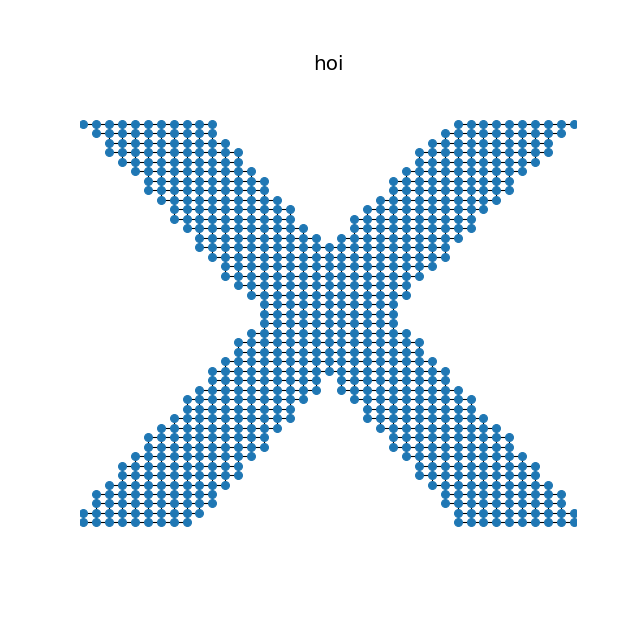

In [18]:
fig = plt.figure(figsize=(8, 8), dpi=80)
fig.tight_layout()
ax = fig.add_subplot()
plot_edge_index(edge_index, coord=target_coord, box_dim=2, title='hoi', ax=ax)

In [23]:
coord2scatter(coord, title=f'hoi {graph}, {loss_fn.__name__}, {seed}', transparent=True, ax=ax, zero_center=True)

1

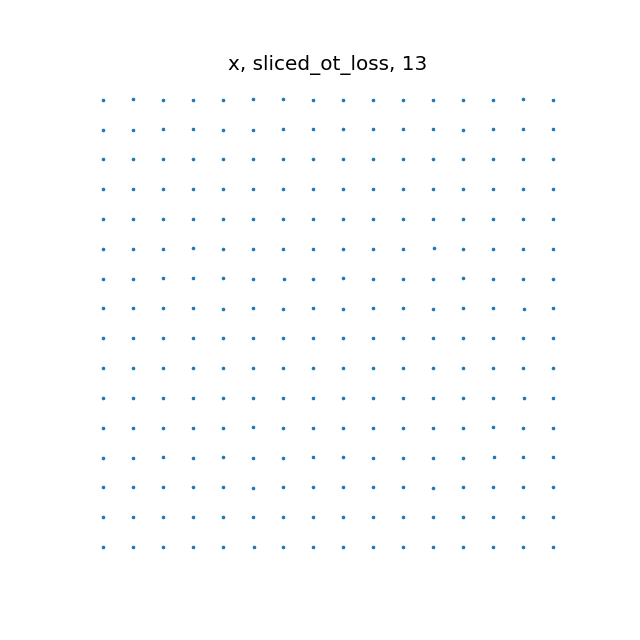

In [21]:
fig = plt.figure(figsize=(8, 8), dpi=80)
fig.tight_layout()
ax = fig.add_subplot()
coord2scatter(coord, title=f'{graph}, {loss_fn.__name__}, {seed}', transparent=True, ax=ax, zero_center=True)
# plot_edge_index(edge_index, coord=coord, box_dim=2, title=f'{graph}, {loss_fn.__name__}, {seed}', ax=ax)
# plt.show()
1

Total time: 98.41811895370483


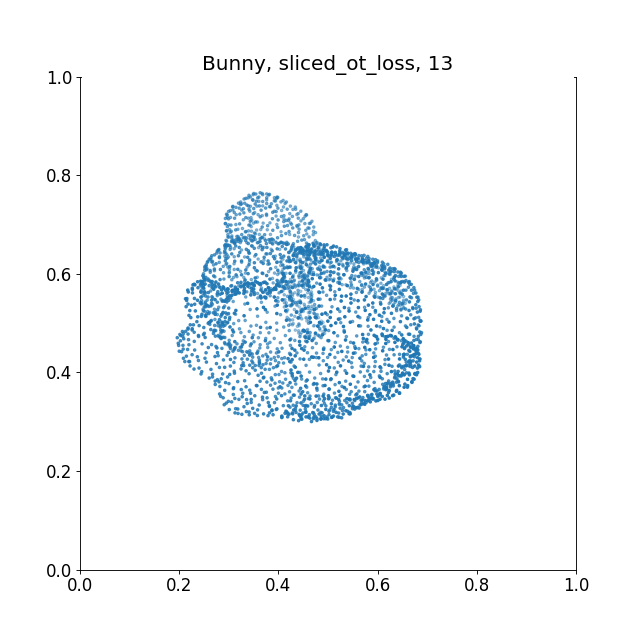

In [30]:
# losses = [original_loss, local_loss, sliced_ot_loss]
losses = [sliced_ot_loss]
losses_kwargs = lambda edge_index: [
    [{}],
    [
        {"edge_index": edge_index, "split_losses": False, "extra_neighbours_penalty": False, "angle_type": "directed"},
        {"edge_index": edge_index, "split_losses": False, "extra_neighbours_penalty": True, "angle_type": "directed"},
        {"edge_index": edge_index, "split_losses": False, "extra_neighbours_penalty": False, "angle_type": "undirected"},
        {"edge_index": edge_index, "split_losses": False, "extra_neighbours_penalty": True, "angle_type": "undirected"},
    ],
    [
        {"n_proj": 128},
        {"n_proj": 256},
        {"n_proj": 512},
        {"n_proj": 1024},
    ]
]
# graphs = ['Grid2d', 'x', 'Cube']
graphs= ['Torus', 'Bunny']
# graphs = ['x']
# seeds = [1, 13, 42, 123, 999, 1234, 1337, 9999, 12345, 54321]
seeds = [1, 13]

device = 'cuda'
lr = 1e-2

fig = plt.figure(figsize=(8, 8), dpi=80)
fig.tight_layout()
ax_2d = fig.add_subplot()
ax_3d = fig.add_subplot(projection='3d')

start_time = time.time()

pb_graphs = tqdm(graphs, desc='Graphs')
loss_values = {}

for graph in pb_graphs:
    pb_graphs.set_postfix_str(f'Graph: {graph}')
    loss_values[graph] = {}
    target_coord, edge_index, _ = get_geometric_graph(graph)
    target_coord = target_coord.to(device)
    edge_index = edge_index.to(device)
    pb_losses = tqdm(zip(losses, losses_kwargs(edge_index)), desc='Losses', leave=False, total=len(losses))
    for loss_fn, loss_kwargs in pb_losses:
        pb_losses.set_postfix_str(f'Loss: {loss_fn.__name__}')
        pb_loss_kwargs = tqdm(enumerate(loss_kwargs), desc='Loss kwargs', leave=False, total=len(loss_kwargs))
        loss_values[graph][loss_fn.__name__] = {}
        for i, loss_kwarg in pb_loss_kwargs:
            if target_coord.shape[-1] == 3 and 'angle_type' in loss_kwarg and loss_kwarg['angle_type'] == 'directed':
                loss_values[graph][loss_fn.__name__][i] = {seed: None for seed in seeds}
                continue
                
            pb_seeds = tqdm(seeds, desc='Seeds', leave=False)
            loss_values[graph][loss_fn.__name__][i] = {}
            for seed in pb_seeds:
                pb_seeds.set_postfix_str(f'Seed: {seed}')
                init_random_seeds(seed, deterministic=False)
                coord = optimize(target_coord, loss_fn, lr=lr, leave_pb=False, **loss_kwarg)
                loss = loss_fn(coord, target_coord, **loss_kwarg)
                loss_values[graph][loss_fn.__name__][i][seed] = float(loss)
                # print(f'Graph: {graph}, Loss: {loss_fn.__name__}({loss_kwargs}), Seed: {seed}')
                # print('Final loss: ', float(loss))
                # print('')

                ax = ax_2d if coord.shape[1] == 2 else ax_3d
                ax.clear()
                coord2scatter(coord, title=f'{graph}, {loss_fn.__name__}, {seed}', transparent=True, ax=ax, zero_center=True)
                fig.savefig(f'../figures/{graph}_{loss_fn.__name__}_{i}_{seed}_{float(loss):.5f}.png')
                # plot_edge_index(edge_index, coord=coord, box_dim=2, title=f'{graph}, {loss_fn.__name__}, {seed}', ax=ax)

print('Total time:', time.time() - start_time)

In [17]:
from pprint import pprint


pprint(loss_values)

{'x': {'local_loss': {0: {1: 0.4874415099620819},
                      1: {1: 0.6236943006515503},
                      2: {1: 0.12729668617248535},
                      3: {1: 0.28360334038734436}},
       'original_loss': {0: {1: 3.901027957908809e-05}},
       'sliced_ot_loss': {0: {1: 0.0008732752176001668},
                          1: {1: 0.0008372528245672584},
                          2: {1: 0.0008534531807526946},
                          3: {1: 0.0008491917978972197}}}}


In [6]:
from tqdm.auto import tqdm
import time

things = ['abc', 'def', 'ghi', 'jkl', 'mno', 'pqr', 'stu', 'vwx', 'yz']

pb_outer = tqdm(things, desc='outer')

for i in pb_outer:
    pb_outer.set_postfix_str(f'outer {i}')
    for j in tqdm(range(10), leave=False):
        time.sleep(0.1)